# Answering Business Questions using SQL

## Introduction

In this project, I will be using SQL skills to answer business questions.  In each step, I will:

- Write a SQL query to extract the relevant data for the task.
- Write a short paragraph, drawing conclusions and explaining the data and/or visualisations.

I will be using a modified version of an SQLite database file called `chinook.db`.  The Chinook database contains information about a fictional digital music shop, with details of artists, albums and songs, as well as information on the shop employees and customers and the customers' transactions.  

The database schema is shown below and more information on the original database can be found [here](https://github.com/lerocha/chinook-database).

![Image](https://github.com/suzieamey86/Repositaurus/blob/images/Chinook%20Schema.png?raw=true)

## Creating Helper Functions

In this project, I will be using python's SQLite module and will use pandas to write queries that produce dataframe outputs.  The advantage of using dataframe outputs is that they will be displayed as tables in my Jupyter notebook.

I will be use a context manager to handle the connection to the SQLite database, this will take care of opening and closing the connection to the database and will ensure I don't accidentally make changes to the database.

I will also create some helper functions in python to save some time.

First, I will import the SQLite3 and pandas libraries, and then:

- Create a `run_query()` function that takes a SQL query as an argument and returns a pandas dataframe of that query.
- Create a `run_command()` function that takes a SQL command as an argument and excutes it using the sqlite module.
- Create a `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database.

This is carried out in the code below.

In [1]:
import sqlite3
import pandas as pd

db = 'chinook.db' 

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

Now, let's check the output of the `show_tables()` function:

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

In this scenario, the Chinook record store has signed a deal with a new record label and needs to decide the first three new albums that will be added to the store, from a list of four, shown in the table below.

| Artist Name | Genre |
| ----------- | ----- |
| Regal | Hip_Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

The record label specialises in artists from the USA, and the new albums will be advertised by Chinook in the USA, so it's important to find out which genres sell the best in the USA.

I will write a query to do this and then create a visualisation of the data using pandas.

In [4]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Now we have a list of genres with the number of tracks for each genre sold in the USA shown as an absolute number and also as a percentage.  

I will now import the libraries needed for visualisation in pandas and then plot a graph to give a visual picture of which genres are the most popular in the USA.

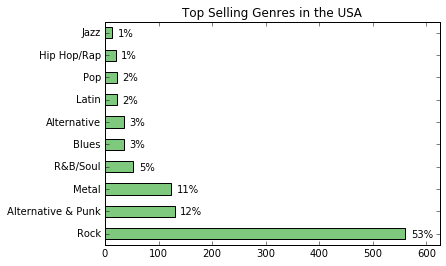

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

The new albums given to Chinook to choose from have the genres of Pop, Hip-Hop, Punk, and Blues.  From the graph above, we can see that the least popular of these four genres is Hip-Hop/Rap, so the three albums which Chinook should choose to add to their store are:

- Red Tone: Punk
- Meteor and the Girls: Pop
- Slim Jim Bites: Blues

The graph also shows that Rock, which is the most popular genre, accounts for more than 50% of sales, so Chinook should look for more albums in this category to add to their inventory.

## Analysing Employee Sales Performance

For this scenario, I will be analysing the performance of Chinook's sales support agents.  Each customer is assigned to a specific sales support agent the first time they make a purchase, so I can look at the cummulative purchases from customers assigned to each sales support agent and see who has made the most sales.

I will also be looking at the hire date of each sales support agent, as I would expect agents who have been employeed for a longer time to have made more sales, so we can test this hypothesis.

In [7]:
employee_sales_performance = '''
WITH support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(srs.total) total_sales
FROM support_rep_sales srs
INNER JOIN employee e ON e.employee_id = srs.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


As I expected, the sales support agent who has been employed the longest has got the highest number of sales, and the agent who was hired most recently has the least, with the difference in sales corresponding roughly to the difference in date of employment.

## Analysing Sales by Country

Next, I will analyse sales data for customers from each different country.  For each country, I will calculate the data for:

- total number of customers.
- total value of sales.
- average value of sales per customer.
- average order value.

In [8]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


The data above shows us that, while they have a small number of customers at present, The Czech Republic, United Kingdom, Portugal and India have a high customer liftime value, or average value of sales per customer.  It may be worth marketing to these coutries to increase the number of customers in these areas, as they appear to be lucrative as far as sale values go.

## Albums vs Individual Tracks

In this final scenario, I am going to find out what percentage of purchases are individual tracks vs whole album purchases.  This information will help the management of the Chinook store to decide whether they should save money by purchasing only the most popular tracks from each album from record companies, instead of buying every track from every album, as they are charged the same price for buying a whole album as if they had bought each track individually.

In [9]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


The data shows that album purchases account for nearly 20%, or a fifth, of the company's revenue.  I would recommend against buying only selected tracks, as this is a considerable percentage of total sales.